In [203]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.preprocessing import PowerTransformer
import warnings
import xgboost as xgb
warnings.filterwarnings('ignore')


In [204]:
df=pd.read_csv('housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [205]:
df.shape

(20640, 10)

In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [207]:
df.dropna(inplace=True)
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [208]:
numeric_cols = df.select_dtypes(include=['number']).columns
print(df[numeric_cols].skew())

longitude            -0.296141
latitude              0.464934
housing_median_age    0.061605
total_rooms           4.158816
total_bedrooms        3.459546
population            4.960017
households            3.413850
median_income         1.644557
median_house_value    0.978290
dtype: float64


In [209]:

pt = PowerTransformer(method='yeo-johnson')
df[numeric_cols] = pt.fit_transform(df[numeric_cols])

print(df[numeric_cols].skew())

longitude             0.000000
latitude              0.153626
housing_median_age   -0.112929
total_rooms           0.122631
total_bedrooms        0.105825
population            0.111574
households            0.110393
median_income        -0.002530
median_house_value   -0.012096
dtype: float64


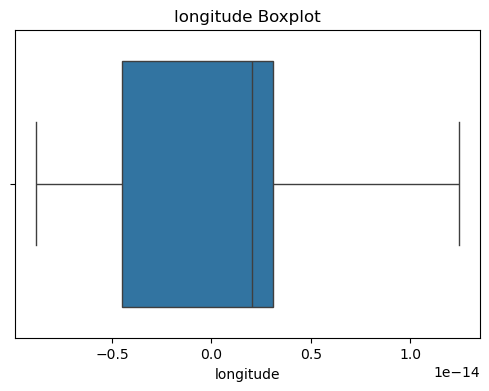

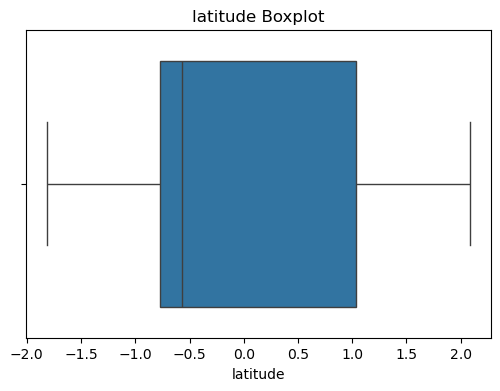

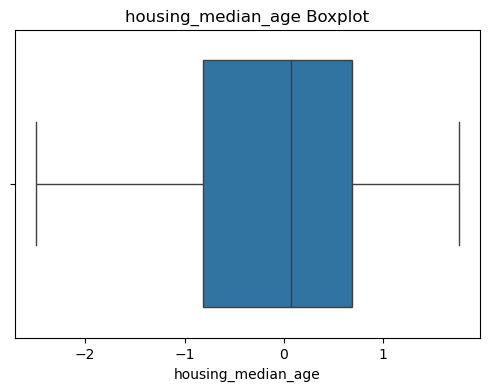

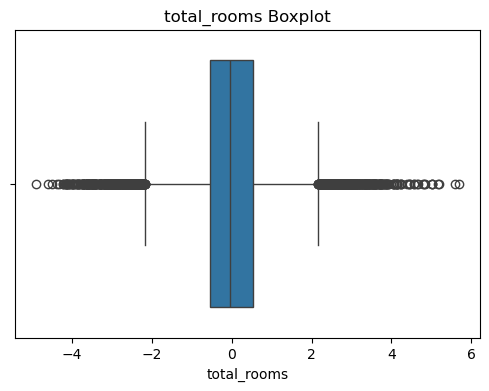

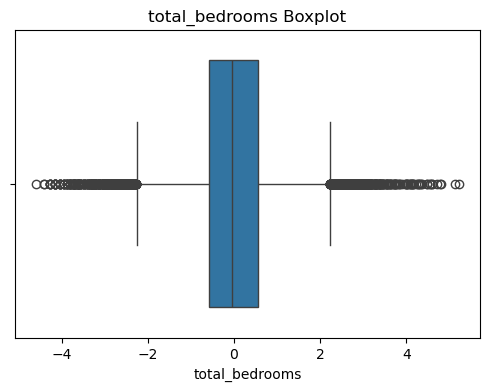

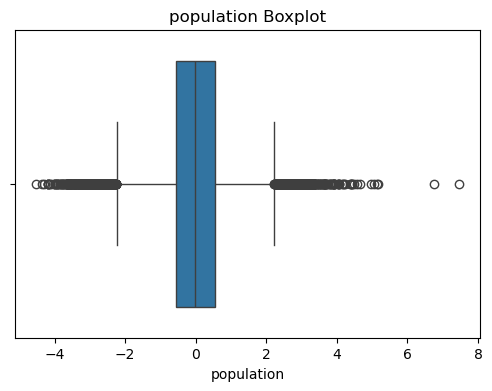

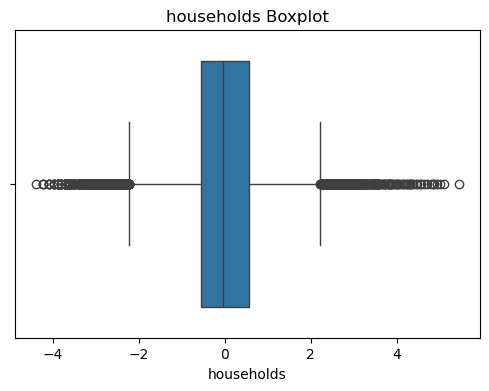

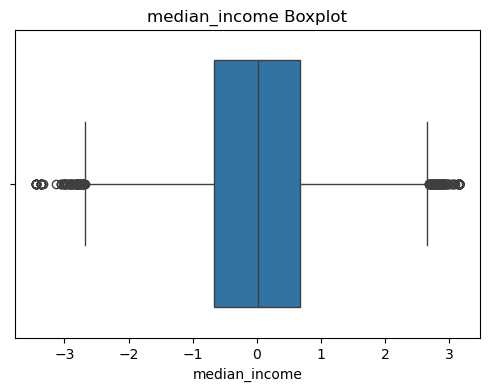

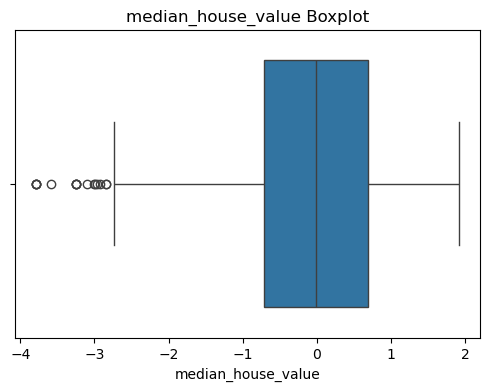

In [210]:
for col in numeric_cols:

    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[col])
    plt.title(f"{col} Boxplot")
    plt.show()

In [211]:
for col in numeric_cols:
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    df[col] = df[col].clip(lower, upper)

In [212]:
df = pd.get_dummies(df, columns=['ocean_proximity'], drop_first=True)


In [213]:
cols = ['ocean_proximity_INLAND', 'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN']
df[cols] = df[cols].astype(int)

In [214]:
scaler = StandardScaler()
X = df.drop('median_house_value', axis=1)
y = df['median_house_value']
X_scaled = scaler.fit_transform(X)

In [215]:


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
xgb = XGBRegressor(random_state=42)
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10]
}
grid = GridSearchCV(xgb, param_grid, scoring=mean_squared_error, cv=5, verbose=2, n_jobs=-1)
grid.fit(X_train, y_train)
print('Best params:', grid.best_params_)



Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


In [216]:
best_xgb = grid.best_estimator_

y_pred = best_xgb.predict(X_test)
r2 = r2_score(y_test, y_pred)
n = X.shape[0]
p = X.shape[1]
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f'R²:{r2}')
print(f'Adjusted R²:{adj_r2}')


R²:0.5503108051718624
Adjusted R²:0.5500465411984081


In [218]:

mse = mean_squared_error(y_test, y_pred)
print(f'XGBoost MSE: {mse:.2f}')
rmse = np.sqrt(mse)
print(f'XGBoost RMSE: {rmse:.2f}')

with open('xgb_house_model.pkl', 'wb') as f:
    pickle.dump(xgb, f)
with open('house_model_columns.pkl', 'wb') as f:
    pickle.dump(list(X.columns), f)


XGBoost MSE: 0.46
XGBoost RMSE: 0.68
